<a href="https://colab.research.google.com/github/AlejandroSepulvedaGuatecique/Projects-in-Ml-and-AI-/blob/main/HW6/TicTacToeHW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIC-TAC-TOE IMPLEMENTATION 

This implementation is based on the following resources. Slightly changes were made regarding the hyperparameters of the reinforcement learning model. Description of the class functionalities are provided thorught out the notebook. Finally, the results are analyzed. 

https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
https://github.com/JaeDukSeo/reinforcement-learning-an-introduction/blob/master/chapter01/TicTacToe.py
https://github.com/JaeDukSeo/reinforcement-learning-an-introduction

### STATE: 
The board is represented as a 3 by 3 grid. The positions will be filled with zeros (available), ones (Player 1 moves) or minus ones (Player 2).
### REWARDS
The rewards are only given at the end of a game. The rewards are given as follows: 1 for a win, -1 for a loss, 0.1 for a tie achieved for the player that started and 0.5 for a tie achieved for the second player. It is known that if you start the game you have more probabilities to win. 

### CLASS STATE

Init

Here, the board is represented (self.data). 
The winner of the game is initalized (self.winner)
The information regarding the end of the game is initalized (self.end)

getHash

The different states played on the board are stored in a state-value dictionary (self.hasVal).


isEnd

This function determine if a player has won the game or a ties has been reached. The code searchs for every row, column and diagonal if the sum returns a 3, player 1 won, if the sum returns a -3, player 2 won, if any player has won and no more positions are available a tie is reached. 

nextState

This function updates the board state after an action is taken by a player. 

show 

This code plot the board for visualization. This is just used when a human is playing. 




In [85]:
from __future__ import print_function
import numpy as np
import pickle

BOARD_ROWS = 3
BOARD_COLS = 3
BOARD_SIZE = BOARD_ROWS * BOARD_COLS

class State:
    def __init__(self):
        # the board is represented by a n * n array,
        # 1 represents chessman of the player who moves first,
        # -1 represents chessman of another player
        # 0 represents empty position
        self.data = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.winner = None
        self.hashVal = None
        self.end = None

    # calculate the hash value for one state, it's unique
    def getHash(self):
        if self.hashVal is None:
            self.hashVal = 0
            for i in self.data.reshape(BOARD_ROWS * BOARD_COLS):
                if i == -1:
                    i = 2
                self.hashVal = self.hashVal * 3 + i
        return int(self.hashVal)

    # determine whether a player has won the game, or it's a tie
    def isEnd(self):
        if self.end is not None:
            return self.end
        results = []
        # check row
        for i in range(0, BOARD_ROWS):
            results.append(np.sum(self.data[i, :]))
        # check columns
        for i in range(0, BOARD_COLS):
            results.append(np.sum(self.data[:, i]))

        # check diagonals
        results.append(0)
        for i in range(0, BOARD_ROWS):
            results[-1] += self.data[i, i]
        results.append(0)
        for i in range(0, BOARD_ROWS):
            results[-1] += self.data[i, BOARD_ROWS - 1 - i]

        for result in results:
            if result == 3:
                self.winner = 1
                self.end = True
                return self.end
            if result == -3:
                self.winner = -1
                self.end = True
                return self.end

        # whether it's a tie
        sum = np.sum(np.abs(self.data))
        if sum == BOARD_ROWS * BOARD_COLS:
            self.winner = 0
            self.end = True
            return self.end

        # game is still going on
        self.end = False
        return self.end

    #  1 or -1
    # put chessman symbol in position (i, j)
    def nextState(self, i, j, symbol):
        newState = State()
        newState.data = np.copy(self.data)
        newState.data[i, j] = symbol
        return newState

    # print the board
    def show(self):
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.data[i, j] == 1:
                    token = '*'
                if self.data[i, j] == 0:
                    token = '0'
                if self.data[i, j] == -1:
                    token = 'x'
                out += token + ' | '
            print(out)
        print('-------------')

def getAllStatesImpl(currentState, currentSymbol, allStates):
    for i in range(0, BOARD_ROWS):
        for j in range(0, BOARD_COLS):
            if currentState.data[i][j] == 0:
                newState = currentState.nextState(i, j, currentSymbol)
                newHash = newState.getHash()
                if newHash not in allStates.keys():
                    isEnd = newState.isEnd()
                    allStates[newHash] = (newState, isEnd)
                    if not isEnd:
                        getAllStatesImpl(newState, -currentSymbol, allStates)

def getAllStates():
    currentSymbol = 1
    currentState = State()
    allStates = dict()
    allStates[currentState.getHash()] = (currentState, currentState.isEnd())
    getAllStatesImpl(currentState, currentSymbol, allStates)
    return allStates

# all possible board configurations
allStates = getAllStates()




### CLASS JUDGER

giveReward

The rewards are only given at the end of a game. The rewards are given as follows: 1 for a win, -1 for a loss, 0.1 for a tie achieved for the player that started and 0.5 for a tie achieved for the second player. It is known that if you start the game you have more probabilities to win. 

reset 

This function reset the board game and it is used before starting a new game. 

play 

This function takes care of the game process. It ensure that the game continues until someone has won or a tie is reached. Also it ensures that all movements are possible. 

In [ ]:
class Judger:
    # @player1: player who will move first, its chessman will be 1
    # @player2: another player with chessman -1
    # @feedback: if True, both players will receive rewards when game is end
    def __init__(self, player1, player2, feedback=True):
        self.p1 = player1
        self.p2 = player2
        self.feedback = feedback
        self.currentPlayer = None
        self.p1Symbol = 1
        self.p2Symbol = -1
        self.p1.setSymbol(self.p1Symbol)
        self.p2.setSymbol(self.p2Symbol)
        self.currentState = State()
        self.allStates = allStates

    # give reward to two players
    def giveReward(self):
        if self.currentState.winner == self.p1Symbol:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif self.currentState.winner == self.p2Symbol:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    def feedCurrentState(self):
        self.p1.feedState(self.currentState)
        self.p2.feedState(self.currentState)

    def reset(self):
        self.p1.reset()
        self.p2.reset()
        self.currentState = State()
        self.currentPlayer = None

    # @show: if True, print each board during the game
    def play(self, show=False):
        self.reset()
        self.feedCurrentState()
        while True:
            # set current player
            if self.currentPlayer == self.p1:
                self.currentPlayer = self.p2
            else:
                self.currentPlayer = self.p1
            if show:
                self.currentState.show()
            [i, j, symbol] = self.currentPlayer.takeAction()
            self.currentState = self.currentState.nextState(i, j, symbol)
            hashValue = self.currentState.getHash()
            self.currentState, isEnd = self.allStates[hashValue]
            self.feedCurrentState()
            if isEnd:
                if self.feedback:
                    self.giveReward()
                return self.currentState.winner

### CLASS PLAYER

feedReward

Here is where the reinforcement learning occurs. Rewards are just given at the end of the game. The state values are updated after the game is finished. a learning rate is defined here as 0.1. The learning rate measures the relevance of the steps taken to reach a good outcome. 

takeAction

Here the exploration and exploitation take place. Iniatially a 10% of the time exploration will take place while the 90% will be used for exploitation. 

save policy

This function saves the policy obtained after training. 


In [ ]:
# AI player
class Player:
    # @stepSize: step size to update estimations
    # @exploreRate: possibility to explore
    def __init__(self, stepSize = 0.1, exploreRate=0.1):
        self.allStates = allStates
        self.estimations = dict()
        self.stepSize = stepSize
        self.exploreRate = exploreRate
        self.states = []

    def reset(self):
        self.states = []

    def setSymbol(self, symbol):
        self.symbol = symbol
        for hash in self.allStates.keys():
            (state, isEnd) = self.allStates[hash]
            if isEnd:
                if state.winner == self.symbol:
                    self.estimations[hash] = 1.0
                else:
                    self.estimations[hash] = 0
            else:
                self.estimations[hash] = 0.5

    # accept a state
    def feedState(self, state):
        self.states.append(state)

    # update estimation according to reward
    def feedReward(self, reward):
        if len(self.states) == 0:
            return
        self.states = [state.getHash() for state in self.states]
        target = reward
        for latestState in reversed(self.states):
            value = self.estimations[latestState] + self.stepSize * (target - self.estimations[latestState])
            self.estimations[latestState] = value
            target = value
        self.states = []

    # determine next action
    def takeAction(self):
        state = self.states[-1]
        nextStates = []
        nextPositions = []
        for i in range(BOARD_ROWS):   
            for j in range(BOARD_COLS):
                if state.data[i, j] == 0:         # Checking for available positions
                    nextPositions.append([i, j])  # store the available position 
                    nextStates.append(state.nextState(i, j, self.symbol).getHash())
        if np.random.binomial(1, self.exploreRate):     # This is for Exploration
            np.random.shuffle(nextPositions)
            # Not sure if truncating is the best way to deal with exploratory step
            # Maybe it's better to only skip this step rather than forget all the history
            self.states = []
            action = nextPositions[0]
            action.append(self.symbol)
            return action    #Position, who played it   ([i,j], -1)

        values = []          # exploitation 
        for hash, pos in zip(nextStates, nextPositions):
            values.append((self.estimations[hash], pos))  #estimations 
        np.random.shuffle(values)                         
        values.sort(key=lambda x: x[0], reverse=True)
        action = values[0][1]   # optimal available Position to play
        action.append(self.symbol) #e.g. ([0,2], -1)
        return action       #Position, who played it   ([i,j], -1)

    def savePolicy(self):
        fw = open('optimal_policy_' + str(self.symbol), 'wb')
        pickle.dump(self.estimations, fw)
        fw.close()

    def loadPolicy(self):
        fr = open('optimal_policy_' + str(self.symbol),'rb')
        self.estimations = pickle.load(fr)
        fr.close()

# human interface
# input a number to put a chessman
# | 1 | 2 | 3 |
# | 4 | 5 | 6 |
# | 7 | 8 | 9 |




CLASS HUMAN PLAYER

This class is defined for human interaction. 

takeaction

This function ask the user to input a position between 1 and 9. 

In [ ]:
class HumanPlayer:
    def __init__(self, stepSize = 0.1, exploreRate=0.1):
        self.symbol = None
        self.currentState = None
        return
    def reset(self):
        return
    def setSymbol(self, symbol):
        self.symbol = symbol
        return
    def feedState(self, state):
        self.currentState = state
        return
    def feedReward(self, reward):
        return
    def takeAction(self):
        data = int(input("Input your position:"))
        data -= 1
        i = data // int(BOARD_COLS)
        j = data % BOARD_COLS
        if self.currentState.data[i, j] != 0:
            return self.takeAction()
        return (i, j, self.symbol)

The model is trained using the train function. After the model is trained, it can be tested using the compete function in which two AI players played against each other.  

In [232]:
def train(epochs=20000):
    player1 = Player()
    player2 = Player()
    judger = Judger(player1, player2)
    player1Win = 0
    player2Win = 0
    P1W = np.zeros(20000)
    P2W = np.zeros(20000)
    for i in range(0, epochs):
        #print("Epoch", i)
        winner = judger.play()
        if winner == 1:
            player1Win += 1
            P1W[player1Win] = player1Win/(i+1)         
        if winner == -1:
            player2Win += 1
            P2W[player2Win] = player2Win/(i+1)
        judger.reset()
    P1W = player1Win / epochs
    P2W = player2Win / epochs
    print(player1Win / epochs)
    print(player2Win / epochs)
    player1.savePolicy()
    player2.savePolicy()
    return P1W, P2W
''' def train(epochs=20000):
    player1 = Player()
    player2 = Player()
    judger = Judger(player1, player2)
    player1Win = 0.0
    player2Win = 0.0
    for i in range(0, epochs):
        print("Epoch", i)
        winner = judger.play()
        if winner == 1:
            player1Win += 1
        if winner == -1:
            player2Win += 1
        judger.reset()
    print(player1Win / epochs)
    print(player2Win / epochs)
    player1.savePolicy()
    player2.savePolicy() '''

def compete(turns=500):
    player1 = Player(exploreRate=0)
    player2 = Player(exploreRate=0)
    judger = Judger(player1, player2, False)
    player1.loadPolicy()
    player2.loadPolicy()
    player1Win = 0.0
    player2Win = 0.0
    player3Win = 0.0
    for i in range(0, turns):
        #print("Epoch", i)
        winner = judger.play()
        if winner == 1:
            player1Win += 1
        if winner == -1:
            player2Win += 1
        else:
            player3Win += 1
        judger.reset()
    P1C = player1Win / turns
    P2C = player2Win / turns
    P3C = player3Win / turns
    print(P1C)
    print(P2C)
    return P1C, P2C, P3C

def play():
    while True:
        player1 = Player(exploreRate=0)
        player2 = HumanPlayer()
        judger = Judger(player1, player2, False)
        player1.loadPolicy()
        winner = judger.play(True)
        if winner == player2.symbol:
            print("Win!")
        elif winner == player1.symbol:
            print("Lose!")
        else:
            print("Tie!")



def ite(epochs_array):
  P1W=np.zeros(len(epochs_array))
  P2W=np.zeros(len(epochs_array))
  P1C=np.zeros(len(epochs_array))
  P2C=np.zeros(len(epochs_array))
  P3C=np.zeros(len(epochs_array))
  count = 0
  for i in epochs_array:
      P1W[count], P2W[count]  = train(epochs=i)
      P1C[count], P2C[count], P3C[count] = compete()
      count += 1
  return P1W, P2W, P1C, P2C, P3C

In [ ]:
epochs_array = np.arange(2,500,5)
P1W, P2W, P1C, P2C, P3C = ite(epochs_array)

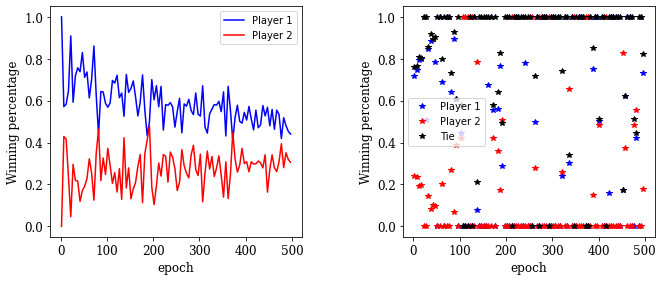

In [244]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(epochs_array,P1W,'-b', label = 'Player 1')
axes[0].plot(epochs_array,P2W,'-r', label = 'Player 2')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('Winning percentage',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(epochs_array,P1C,'*b', label = 'Player 1')
axes[1].plot(epochs_array,P2C,'*r', label = 'Player 2')
axes[1].plot(epochs_array,P3C,'*k', label = 'Tie')

axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('Winning percentage',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

The figure at the left shows the winning percentage after training the model with a number of epochs. While the figure at the right shows the winning percentage when the compete function is used based on the trained models. 

Player 1 initially dominates the games at the beginning of the process. Since the model was trained using a limited number of epochs, this is to be expected, and the likelihood that the player who initiates the game would win has a greater internal probability. This behavior is reduced as the number of train epochs getting close the winning percentage of both models. Also, for a large number of train epochs the tie outcome is the more likely to happen. This is a solid sign of a well trained model. 

In [245]:
def train(epochs=20000):
    player1 = Player(stepSize = 0.999, exploreRate=0.3)
    player2 = Player(stepSize = 0.999, exploreRate=0.3)
    judger = Judger(player1, player2)
    player1Win = 0
    player2Win = 0
    P1W = np.zeros(20000)
    P2W = np.zeros(20000)
    for i in range(0, epochs):
        #print("Epoch", i)
        winner = judger.play()
        if winner == 1:
            player1Win += 1
            P1W[player1Win] = player1Win/(i+1)         
        if winner == -1:
            player2Win += 1
            P2W[player2Win] = player2Win/(i+1)
        judger.reset()
    P1W = player1Win / epochs
    P2W = player2Win / epochs
    print(player1Win / epochs)
    print(player2Win / epochs)
    player1.savePolicy()
    player2.savePolicy()
    return P1W, P2W
''' def train(epochs=20000):
    player1 = Player()
    player2 = Player()
    judger = Judger(player1, player2)
    player1Win = 0.0
    player2Win = 0.0
    for i in range(0, epochs):
        print("Epoch", i)
        winner = judger.play()
        if winner == 1:
            player1Win += 1
        if winner == -1:
            player2Win += 1
        judger.reset()
    print(player1Win / epochs)
    print(player2Win / epochs)
    player1.savePolicy()
    player2.savePolicy() '''

def ite(epochs_array):
  P1W=np.zeros(len(epochs_array))
  P2W=np.zeros(len(epochs_array))
  P1C=np.zeros(len(epochs_array))
  P2C=np.zeros(len(epochs_array))
  P3C=np.zeros(len(epochs_array))
  count = 0
  for i in epochs_array:
      P1W[count], P2W[count]  = train(epochs=i)
      P1C[count], P2C[count], P3C[count] = compete()
      count += 1
  return P1W, P2W, P1C, P2C, P3C


In [ ]:
epochs_array = np.arange(2,5000,100)
P1W, P2W, P1C, P2C, P3C = ite(epochs_array)

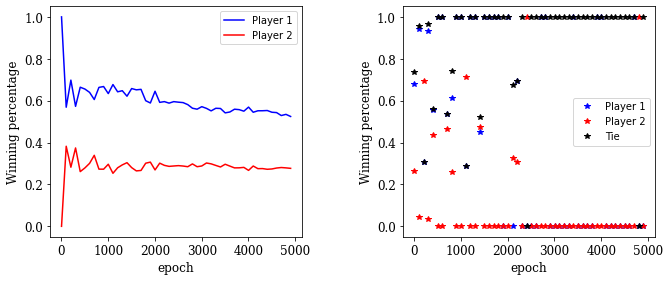

In [249]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
fig.subplots_adjust(wspace=0.4,hspace=0,left=0.2, right=0.9, top=0.9, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}
axes[0].plot(epochs_array,P1W,'-b', label = 'Player 1')
axes[0].plot(epochs_array,P2W,'-r', label = 'Player 2')
axes[0].set_xlabel('epoch',fontdict)
axes[0].set_ylabel('Winning percentage',fontdict)
#axes[0].set_ylim(0.14, 0.18)
axes[0].legend()

axes[1].plot(epochs_array,P1C,'*b', label = 'Player 1')
axes[1].plot(epochs_array,P2C,'*r', label = 'Player 2')
axes[1].plot(epochs_array,P3C,'*k', label = 'Tie')

axes[1].set_xlabel('epoch',fontdict)
axes[1].set_ylabel('Winning percentage',fontdict)
#axes[1].set_ylim(0.94, 0.95)
axes[1].legend()

for tick in axes[0].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[0].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

for tick in axes[1].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)
for tick in axes[1].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(12)

The preivous conclusions are clear when the number of epochs is taken to 5000. Note that the winning percantage in the training section is larger for player 1, even after a large number of epochs. This is because the exploratory step is used 30% of the times, which will tend to give more winnings to Player 1. 

Finally, a human can play against the trained AI. 

In [ ]:
play()

-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
Input your position:1
-------------
| x | 0 | * | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
-------------
| x | 0 | * | 
-------------
| 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 
-------------
Input your position:9
-------------
| x | 0 | * | 
-------------
| 0 | 0 | * | 
-------------
| 0 | 0 | x | 
-------------
-------------
| x | 0 | * | 
-------------
| 0 | * | * | 
-------------
| 0 | 0 | x | 
-------------
Input your position:7
-------------
| x | 0 | * | 
-------------
| 0 | * | * | 
-------------
| x | 0 | x | 
-------------
Lose!
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------
-------------
| 0 | 0 | * | 
-------------
| 0 | 0 | 0 | 
-------------
| 0 | 0 | 0 | 
-------------


The AI player was able to select the right moves to win the game. 